# Wines Points prediction 

## Gil LAIFER (028482636) - TCDS17 6.5.2022

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [2]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [3]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [4]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
109925,109925,Italy,"Bold and full bodied, this opens with rather s...",Pajè Riserva,93,58.0,Piedmont,Barbaresco,NaN,Kerin O’Keefe,@kerinokeefe,Produttori del Barbaresco 2011 Pajè Riserva (...,Nebbiolo,Produttori del Barbaresco
112314,112314,France,Soft notes of earth and gentle red fruit appea...,Collection,86,29.0,Alsace,Alsace,NaN,Anne Krebiehl MW,@AnneInVino,Kuentz-Bas 2013 Collection Pinot Noir (Alsace),Pinot Noir,Kuentz-Bas
104053,104053,Australia,It's good to see this Margaret River stalwart ...,DJL,92,20.0,Western Australia,Margaret River,NaN,Joe Czerwinski,@JoeCz,Xanadu 2015 DJL Chardonnay (Margaret River),Chardonnay,Xanadu
59664,59664,US,"The fruit is thin and herbal, with light hints...",NaN,85,17.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Maryhill 2011 Syrah (Columbia Valley (WA)),Syrah,Maryhill
61833,61833,US,Generous fruit flavors of strawberry preserves...,Skyraider Reserve,89,60.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Vista Hills 2009 Skyraider Reserve Pinot Noir ...,Pinot Noir,Vista Hills


In [5]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [6]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews.shape

(119988, 13)

## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [7]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [8]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [10]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [11]:
test_data['baseline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'baseline_1_predicted_points', 'points')
b1_stats

MSE    9.684853
MAE    2.558104
R2    -0.000009
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [12]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.660191
Armenia                   87.000000
Australia                 88.538240
Austria                   90.134187
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [13]:
test_data['baseline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'baseline_2_predicted_points', 'points')
b2_stats

MSE    9.168517
MAE    2.481975
R2     0.053305
dtype: float64

### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [14]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('baseline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.774035
           Other               85.962217
Armenia    Armenia             87.000000
Australia  Australia Other     85.582418
           New South Wales     87.803030
Name: baseline_3_predicted_points, dtype: float64

In [15]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.baseline_3_predicted_points = test_data_with_baseline_3.baseline_3_predicted_points.fillna(test_data_with_baseline_3.baseline_2_predicted_points).fillna(test_data.baseline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 16), (23998, 15))

In [16]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'baseline_3_predicted_points', 'points')
b3_stats

MSE    8.599106
MAE    2.382239
R2     0.112099
dtype: float64

### Baselines summary

In [17]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.684853,2.558104,-0.000009
baseline_2,9.168517,2.481975,0.053305
baseline_3,8.599106,2.382239,0.112099


In [18]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Label encoding categorical features

In [20]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [21]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [22]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

#### Fitting a tree-regressor

In [23]:
from src.models import i_feel_lucky_xgboost_training

In [24]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 0 to 129969
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int32  
 1   province     95990 non-null  int32  
 2   region_1     95990 non-null  int32  
 3   region_2     95990 non-null  int32  
 4   taster_name  95990 non-null  int32  
 5   variety      95990 non-null  int32  
 6   winery       95990 non-null  int32  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int32(7), int64(1)
memory usage: 4.8 MB


In [25]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [26]:
test_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,xgb_clf_points_prediction
1,32,108,738,6,16,451,12956,15.0,87,87
11,15,11,21,6,16,209,9963,30.0,87,88
15,17,232,738,6,1,480,13236,24.0,87,90
27,22,332,1063,6,9,389,14472,10.0,87,87
34,41,51,1019,13,14,515,6957,20.0,86,87


In [27]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.375198
MAE    1.912409
R2     0.341729
dtype: float64

In [28]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

,MSE,MAE,R2
baseline_1,9.684853,2.558104,-0.000009
baseline_2,9.168517,2.481975,0.053305
baseline_3,8.599106,2.382239,0.112099
regression_by_xgb,6.375198,1.912409,0.341729


In [29]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Classical NLP approaches

### Using only the text from the "description" column

#### Text tokenization

In [30]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omriL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omriL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\omriL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [31]:
from pandas import * 
import cufflinks as cf; cf.go_offline()

In [32]:
set_option('display.max_colwidth',200)

In [33]:
wine_reviews.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [34]:
!pip install ttp

In [35]:
!pip install emoji

In [36]:
import string
import emoji
import re as regex

In [37]:
specialChars = ''.join([",", ":", "\"", "=", "&", ";", "%", "$","@", "%", "^", "*", "(", ")", "{", "}",'–','“', '”'
                      "[", "]", "|", "/", "\\", ">", "<", "-","!", "?", ".", "'","--", "---", "#", '‘', '’', '…'])  
space_chars = ['.',',',';', '&', '?','!']
def remove_by_regex(description, regexp):
    return description.replace(regexp, "")

def remove_urls(description):
    return remove_by_regex(description, regex.compile(r"http\S+"))

def remove_special_chars(description): 
    return description.apply(lambda desc: ''.join([c for c in desc if c not in specialChars]))

def remove_usernames(description):
    return remove_by_regex(description, regex.compile(r"@[^\s]+[\s]?"))

def remove_numbers(description):
    return remove_by_regex(description, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

def remove_emojis(description):
    return description.apply(lambda desc: ''.join(c for c in desc if c not in emoji.UNICODE_EMOJI))

def add_spaces(descriptions):
    def add_spaces_int(description):
        for char in space_chars:
            description = description.replace(char, char + ' ')
        return description
    return descriptions.apply(lambda desc: add_spaces_int(desc))

def leave_language_only(descriptions):
    for f in [remove_urls, remove_emojis, add_spaces, remove_numbers, remove_usernames, remove_special_chars]:
        descriptions = f(descriptions)
    return descriptions

Generating df - a DataFrame with the original 'description' and 'points' variables and a new 'pureTextDescription' variable which will be used for Tokenization. 

In [38]:
df = DataFrame(wine_reviews['description'])
df['y'] = wine_reviews['points']

In [39]:
df['pureTextDescription'] = leave_language_only(df.description.str.lower())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   description          119988 non-null  object
 1   y                    119988 non-null  int64 
 2   pureTextDescription  119988 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [40]:
stopwords=nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("italian") + nltk.corpus.stopwords.words("spanish")
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [41]:
nltk.word_tokenize(df.pureTextDescription.iloc[0])

['aromas',
 'include',
 'tropical',
 'fruit',
 'broom',
 'brimstone',
 'and',
 'dried',
 'herb',
 'the',
 'palate',
 'isnt',
 'overly',
 'expressive',
 'offering',
 'unripened',
 'apple',
 'citrus',
 'and',
 'dried',
 'sage',
 'alongside',
 'brisk',
 'acidity']

Tokenizing the dataset text using the pureTextDescription feature:

In [42]:
all_words = [word for desc in df.pureTextDescription for word in nltk.word_tokenize(desc) if word.lower() not in stopwords] # Words without stop words
words_df = DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head()

,word,wordCount,wordImportance
0,wine,72157,0.000009
1,flavors,57958,0.000011
2,fruit,41575,0.000015
3,aromas,36242,0.000017
4,palate,34726,0.000018


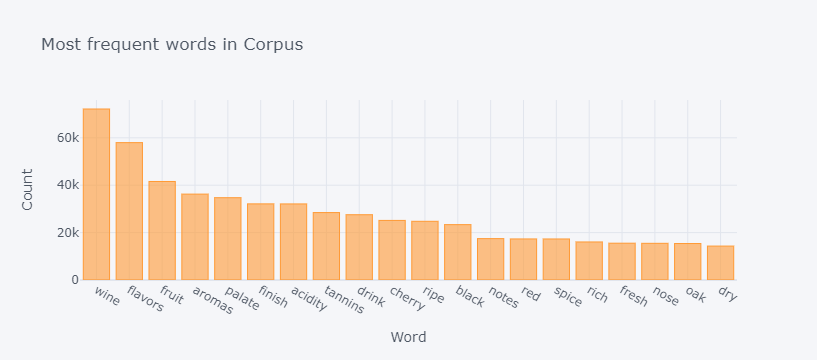

In [43]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [44]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))

Total of 2949360 words, 44567 unique words


to reduce the corpus size more, we probably don't care about words that appear too little. Let's drop any word which have under 5 appearnces:

In [45]:
print ("Using words with 5 or more appearnces will reduce the corpus size to: {}".format(sum(words_df.wordCount >= 5)))

Using words with 5 or more appearnces will reduce the corpus size to: 13075


In [46]:
words_df = words_df[words_df.wordCount >= 5]

#### Bag of words (One-hot-encoding)

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
clean_vocab = set(words_df.word)
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)
clean_bow_counts = count_vect.fit_transform(df.pureTextDescription)
clean_bow_counts.shape

(119988, 13075)

In [49]:
df.iloc[1].pureTextDescription

'this is ripe and fruity  a wine that is smooth while still structured  firm tannins are filled out with juicy red berry fruits and freshened with acidity  its  already drinkable  although it will certainly be better from '

In [50]:
print(clean_bow_counts[1])

  (0, 76)	1
  (0, 271)	1
  (0, 280)	1
  (0, 941)	1
  (0, 961)	1
  (0, 1814)	1
  (0, 3426)	1
  (0, 4203)	1
  (0, 4247)	1
  (0, 4554)	1
  (0, 4633)	1
  (0, 4636)	1
  (0, 5987)	1
  (0, 9187)	1
  (0, 9529)	1
  (0, 10517)	1
  (0, 10936)	1
  (0, 11050)	1
  (0, 11439)	1
  (0, 12843)	1


In [51]:
rev_dict = {v:k for k,v in count_vect.vocabulary_.items()}
print(rev_dict[76])
print(rev_dict[271])
print(rev_dict[280])
print(rev_dict[941])

acidity
already
although
berry


In [52]:
clean_bow_counts.sum()

2900818

### Training and testing on the entire dataset (no split to test/train)
(1) Cross-validation for searching the optimal regularization level<br>
(2) Predicting 'points' using optimal regularization level on the entire dataset and evaluating prediction quality

In [53]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [55]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
mse_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha = alpha, tol=0.0001, max_iter=10000)
    avg_score = cross_val_score(model, clean_bow_counts, y = df.y, cv = 10, scoring = 'neg_mean_squared_error').mean()
    mse_by_alpha.append((alpha,abs(avg_score)))

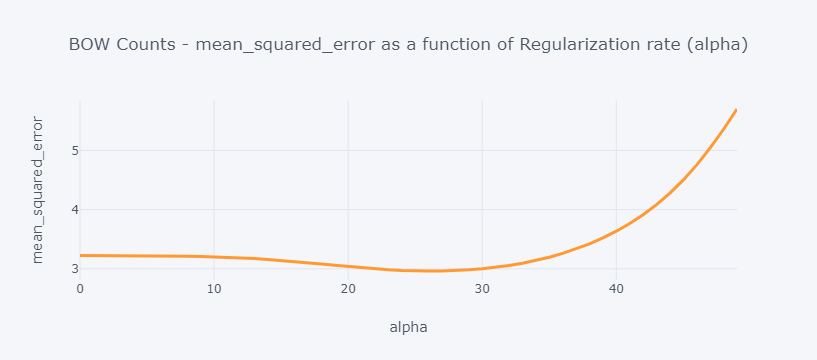

In [56]:
cv_results = DataFrame(mse_by_alpha, columns = ['alpha', 'mean_squared_error'])
cv_results.mean_squared_error.iplot(title = 'BOW Counts - mean_squared_error as a function of Regularization rate (alpha)', xTitle = 'alpha', yTitle = 'mean_squared_error', width = 3, hline=(0,0))

In [57]:
opt_alpha, min_mean_squared_error = cv_results.loc[cv_results.mean_squared_error.idxmin()]
print(opt_alpha, min_mean_squared_error)

15.264179671752334 2.963803105209001


#### Predicting 'points' with the optimal model and evaluating prediction quality

In [58]:
model = Ridge(alpha = opt_alpha, tol=0.0001, max_iter=10000)
model.fit(clean_bow_counts, df.y)

Ridge(alpha=15.264179671752334, max_iter=10000, tol=0.0001)

In [59]:
df['predicted_score'] = model.predict(clean_bow_counts)

In [60]:
NLP_desc_stats = calc_prediction_quality(df, 'predicted_score','y')
NLP_desc_stats

MSE    2.571613
MAE    1.266684
R2     0.731173
dtype: float64

In [61]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_desc_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'NLP_desc_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.684853,2.558104,-0.000009
baseline_2,9.168517,2.481975,0.053305
baseline_3,8.599106,2.382239,0.112099
regression_by_xgb,6.375198,1.912409,0.341729
NLP_desc_stats,2.571613,1.266684,0.731173


In [62]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

### Using both the text and other features
#### Training and testing on the entire dataset (no split to test/train)

In [63]:
other_features = encoded_features[['country', 'province', 'region_1', 'region_2', 'taster_name', 'variety', 'winery', 'price']]
other_features

,country,province,region_1,region_2,taster_name,variety,winery,price
0,22,332,424,6,9,691,11608,-1.0
1,32,108,738,6,16,451,12956,15.0
2,41,269,1218,17,15,437,13018,14.0
3,41,218,549,6,0,480,14390,13.0
4,41,269,1218,17,15,441,14621,65.0
...,...,...,...,...,...,...,...,...
129966,17,232,738,6,1,480,6643,28.0
129967,41,269,788,11,15,441,4776,75.0
129968,15,11,21,6,16,209,5929,30.0
129969,15,11,21,6,16,437,6027,32.0


In [64]:
from scipy.sparse import coo_matrix, hstack
#other_features_spares_matrix = coo_matrix(other_features) # no need to apply coo_matrix as hstack converts to sparse matrix authomatically
train_united_features = hstack((clean_bow_counts ,other_features))

In [65]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
mse_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha = alpha, tol=0.0001, max_iter=10000)
    avg_score = cross_val_score(model, train_united_features, y = df.y, cv = 10, scoring = 'neg_mean_squared_error').mean()
    mse_by_alpha.append((alpha,abs(avg_score)))

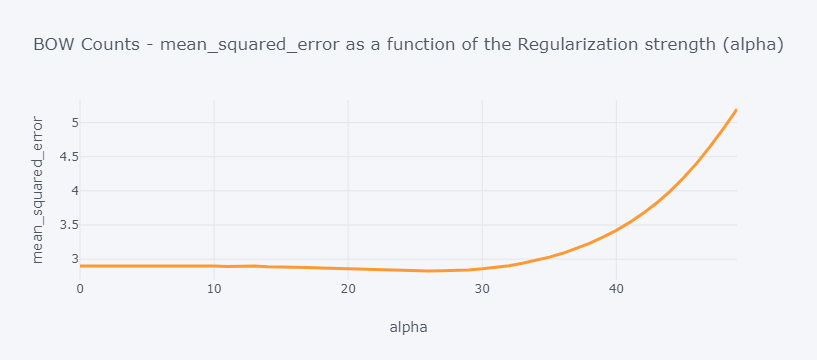

In [66]:
cv_results = DataFrame(mse_by_alpha, columns = ['alpha', 'mean_squared_error'])
cv_results.mean_squared_error.iplot(title = 'BOW Counts - mean_squared_error as a function of the Regularization strength (alpha)', xTitle = 'alpha', yTitle = 'mean_squared_error', width = 3, hline=(0,0))

In [67]:
opt_alpha, min_mean_squared_error = cv_results.loc[cv_results.mean_squared_error.idxmin()]
print(opt_alpha, min_mean_squared_error)

11.513953993264469 2.826841228104473


In [68]:
model = Ridge(alpha = opt_alpha, tol=0.0001, max_iter=10000)
model.fit(train_united_features, df.y)

Ridge(alpha=11.513953993264469, max_iter=10000, tol=0.0001)

In [69]:
df['predicted_score_extended_NLP'] = model.predict(train_united_features)

In [70]:
extended_NLP_stats = calc_prediction_quality(df, 'predicted_score_extended_NLP','y')
extended_NLP_stats

MSE    2.489510
MAE    1.238033
R2     0.739756
dtype: float64

In [71]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_desc_stats, extended_NLP_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'NLP_desc_stats', 'extended_NLP_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.684853,2.558104,-0.000009
baseline_2,9.168517,2.481975,0.053305
baseline_3,8.599106,2.382239,0.112099
regression_by_xgb,6.375198,1.912409,0.341729
NLP_desc_stats,2.571613,1.266684,0.731173
extended_NLP_stats,2.489510,1.238033,0.739756


Adding more features to the text resulted in improvement MSE (as well as on the other metrics). This is the expected result as we added more features to the model. The improvement is not significant though.

In [72]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Deep Learning approaches

### Fully connected network on the 'description' text feature only

#### (1) Internal embedding layer + average pooling

##### Tokenization and vectorization:

In [73]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [74]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [75]:
vocab_size = 32000
sequence_length = 72

# Use the text vectorization layer to normalize, split, and map strings to integers. 
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

Computing the vocabulary of the TextVectorization layer based on the 'description' variable:


In [76]:
vectorize_layer.adapt(train_data['description'])

In [77]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)

Pretty full-bodied for a rosé, with a copper-pink color and upfront red currant, raspberry cream, vanilla and cinnamon flavors that finish a little sweet. The acidity is just fine. Nice with charcuterie.


In [78]:
vectorize_layer(sample_description)

<tf.Tensor: shape=(72,), dtype=int64, numpy=
array([ 227,  146,   31,    4,  386,    6,    4, 7603,  176,    2, 1054,
         34,  123,   74,  565,   64,    2,  213,   11,   19,   20,    4,
        185,   51,    3,   21,    8,  104,  114,  260,    6, 3416,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int64)>

In [79]:
vectorize_layer(sample_description).numpy()[:20]

array([ 227,  146,   31,    4,  386,    6,    4, 7603,  176,    2, 1054,
         34,  123,   74,  565,   64,    2,  213,   11,   19], dtype=int64)

In [80]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

227 --->  pretty
146 --->  fullbodied
31 --->  for
4 --->  a
386 --->  rosé
6 --->  with
4 --->  a
7603 --->  copperpink
176 --->  color
2 --->  and
1054 --->  upfront
34 --->  red
123 --->  currant
74 --->  raspberry
565 --->  cream
64 --->  vanilla
2 --->  and
213 --->  cinnamon
11 --->  flavors
19 --->  that


##### Modeling (Sequential API):

Total model parameters: 514,953

In [81]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 72)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 72, 16)            512000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout (Dropout)           (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 1

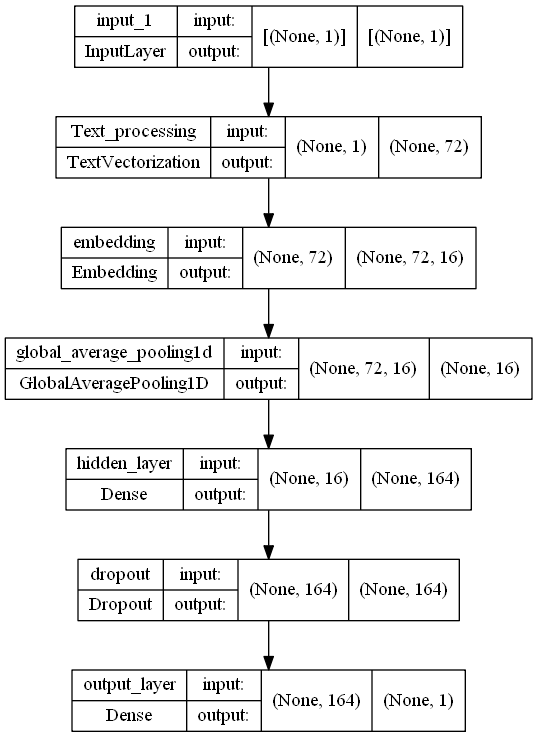

In [83]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [84]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [85]:
train_data.shape

(95990, 13)

In [86]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 17s 21ms/step - loss: 22.2830 - mean_squared_error: 1380.5846 - mean_absolute_error: 22.2830 - val_loss: 2.5498 - val_mean_squared_error: 9.7179 - val_mean_absolute_error: 2.5498
Epoch 2/20
750/750 [==============================] - 15s 20ms/step - loss: 3.5661 - mean_squared_error: 19.8993 - mean_absolute_error: 3.5661 - val_loss: 1.8763 - val_mean_squared_error: 5.4466 - val_mean_absolute_error: 1.8763
Epoch 3/20
750/750 [==============================] - 15s 20ms/step - loss: 3.1819 - mean_squared_error: 15.9251 - mean_absolute_error: 3.1819 - val_loss: 1.5270 - val_mean_squared_error: 3.7028 - val_mean_absolute_error: 1.5270
Epoch 4/20
750/750 [==============================] - 15s 20ms/step - loss: 3.1027 - mean_squared_error: 15.1897 - mean_absolute_error: 3.1027 - val_loss: 1.4597 - val_mean_squared_error: 3.4005 - val_mean_absolute_error: 1.4597
Epoch 5/20
750/750 [==============================] - 15s 20ms/step - loss: 3.07

##### Model evaluation:

In [87]:
test_data['predicted_score_fully_connected_NN'] = model.predict(test_data[text_col])

In [88]:
fully_connected_NN_stats = calc_prediction_quality(test_data, 'predicted_score_fully_connected_NN', target_col)
fully_connected_NN_stats

MSE    2.935073
MAE    1.352488
R2     0.696939
dtype: float64

In [89]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_desc_stats, extended_NLP_stats, fully_connected_NN_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'NLP_desc_stats', 'extended_NLP_stats', 'fully_connected_NN'])
all_compared

,MSE,MAE,R2
baseline_1,9.684853,2.558104,-0.000009
baseline_2,9.168517,2.481975,0.053305
baseline_3,8.599106,2.382239,0.112099
regression_by_xgb,6.375198,1.912409,0.341729
NLP_desc_stats,2.571613,1.266684,0.731173
extended_NLP_stats,2.489510,1.238033,0.739756
fully_connected_NN,2.935073,1.352488,0.696939


In [90]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

#### (2) Fully connected NN with internal embedding and concatination (instead of average pooling)

The concatination is performed by reshaping of the outputs of the embedding layer to 1D vector

##### Modeling (Sequential API):

Total model parameters: 701,257

In [91]:
from tensorflow.keras.layers import Reshape, Dense, Dropout
from tensorflow.keras import Sequential

In [92]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.7),
    Dense(1, activation='linear', name = 'output_layer')
])

In [93]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 72)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 72, 16)            512000    
                                                                 
 concat_words (Reshape)      (None, 1152)              0         
                                                                 
 hidden_layer (Dense)        (None, 164)               189092    
                                                                 
 dropout_1 (Dropout)         (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 165       
                                                      

In [94]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

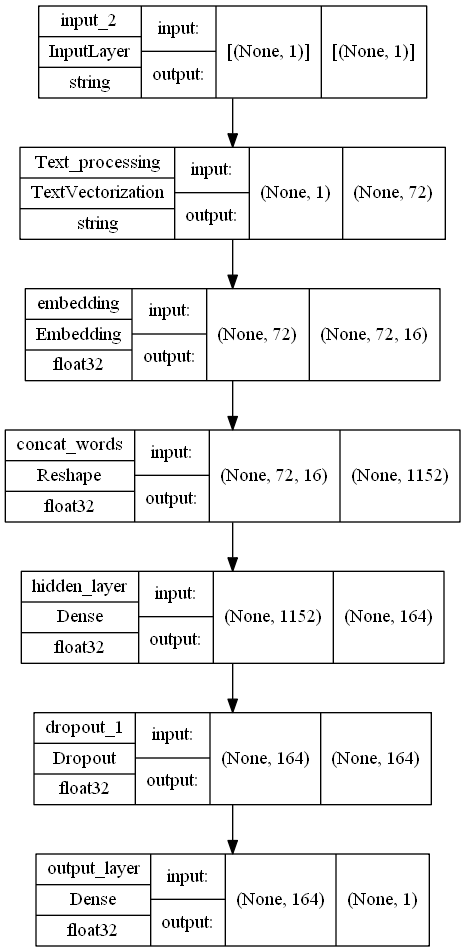

In [95]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [96]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 17s 22ms/step - loss: 24.3496 - mean_squared_error: 1092.7155 - mean_absolute_error: 24.3496 - val_loss: 2.7028 - val_mean_squared_error: 11.3856 - val_mean_absolute_error: 2.7028
Epoch 2/20
750/750 [==============================] - 16s 21ms/step - loss: 8.6952 - mean_squared_error: 118.3838 - mean_absolute_error: 8.6952 - val_loss: 2.7042 - val_mean_squared_error: 11.4081 - val_mean_absolute_error: 2.7042
Epoch 3/20
750/750 [==============================] - 16s 21ms/step - loss: 8.6735 - mean_squared_error: 117.9226 - mean_absolute_error: 8.6735 - val_loss: 2.6124 - val_mean_squared_error: 10.3889 - val_mean_absolute_error: 2.6124
Epoch 4/20
750/750 [==============================] - 16s 21ms/step - loss: 8.6432 - mean_squared_error: 116.9605 - mean_absolute_error: 8.6432 - val_loss: 2.7496 - val_mean_squared_error: 11.8898 - val_mean_absolute_error: 2.7496
Epoch 5/20
750/750 [==============================] - 15s 21ms/step - los

##### Model evaluation:

In [97]:
test_data['predicted_score_FC_NN_concatinated_words'] = model.predict(test_data[text_col])

In [98]:
fully_connected_NN_concatinated_words_stats = calc_prediction_quality(test_data, 'predicted_score_FC_NN_concatinated_words', target_col)
fully_connected_NN_concatinated_words_stats

MSE    10.388935
MAE     2.612426
R2     -0.072709
dtype: float64

In [99]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_desc_stats, extended_NLP_stats, fully_connected_NN_stats, fully_connected_NN_concatinated_words_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'NLP_desc_stats', 'extended_NLP_stats', 'fully_connected_NN', 'fully_connected_NN_concatinated_words'])
all_compared

,MSE,MAE,R2
baseline_1,9.684853,2.558104,-0.000009
baseline_2,9.168517,2.481975,0.053305
baseline_3,8.599106,2.382239,0.112099
regression_by_xgb,6.375198,1.912409,0.341729
NLP_desc_stats,2.571613,1.266684,0.731173
extended_NLP_stats,2.489510,1.238033,0.739756
fully_connected_NN,2.935073,1.352488,0.696939
fully_connected_NN_concatinated_words,10.388935,2.612426,-0.072709


By concatinating the embedding output vectors, instead of average pooling, we increased the number of parameters from 514,953 to 701,257 which increases the risk for overfitting. This may explain the degradation we see across the evaluation metrics.  

In [100]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

#### (3) Fully connected network, using the external GloVe embedding

In [101]:
import os

##### Creating a dictionary with the pre-trained GloVe word embeddings:

In [102]:
filename = "glove.6B.50d.txt"
mypath = os.getcwd()
path_to_glove_file = mypath + "\\data\\" + filename
path_to_glove_file

embeddings_index = {}   # the disctionary storing the GloVe words and their respective embedding vector  
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

f.close()

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [103]:
embeddings_index.get('drinking')

array([-0.05289  ,  0.26076  , -0.85169  , -0.74672  , -0.71359  ,
        0.53861  , -0.34331  , -0.0039209,  0.84767  ,  1.0095   ,
       -0.055063 ,  0.10804  ,  0.75691  , -0.67601  ,  0.9791   ,
        0.058604 ,  0.052446 ,  0.87095  , -0.093627 , -1.0251   ,
        0.71056  ,  0.65858  ,  1.2839   ,  0.43429  ,  0.22294  ,
       -1.0757   ,  0.33904  ,  0.67773  ,  1.2916   ,  0.73883  ,
        2.2522   ,  0.63342  , -0.45855  , -0.31717  ,  0.25738  ,
        0.67247  ,  0.044691 ,  0.37343  ,  0.91146  ,  0.75325  ,
       -0.32958  ,  0.31682  , -0.13106  ,  1.0679   ,  0.85072  ,
       -0.1199   , -1.0389   , -0.63142  ,  1.0357   , -0.4152   ],
      dtype=float32)

Creating a word embedding matrix with a word embedding vector for each word of the wine_reviews vocabulary:

In [104]:
embedding_matrix = np.zeros((vocab_size, 50))

In [105]:
out_of_glove_vocub = []
i = 0
for word in vectorize_layer.get_vocabulary():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        out_of_glove_vocub.append((i, vectorize_layer.get_vocabulary()[i]))     # record the words that do not have an embedding   
    i = i + 1

In [106]:
out_of_glove_vocub[:10]

[(0, ''),
 (1, '[UNK]'),
 (146, 'fullbodied'),
 (297, 'mediumbodied'),
 (448, 'midpalate'),
 (540, 'offdry'),
 (545, 'finegrained'),
 (571, 'blackfruit'),
 (606, 'winerys'),
 (632, 'easydrinking')]

##### Creating the embedding layer:

In [107]:
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=50,
                            weights=[embedding_matrix],
                            input_length=sequence_length,
                            trainable=False)

##### Modeling (Sequential API)

In [108]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [109]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 72)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 72, 50)            1600000   
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 164)               8364      
                                                                 
 dropout_2 (Dropout)         (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                

In [110]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [111]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 12s 15ms/step - loss: 23.8958 - mean_squared_error: 1356.5234 - mean_absolute_error: 23.8958 - val_loss: 2.4305 - val_mean_squared_error: 10.0182 - val_mean_absolute_error: 2.4305
Epoch 2/20
750/750 [==============================] - 10s 14ms/step - loss: 3.6157 - mean_squared_error: 20.7928 - mean_absolute_error: 3.6157 - val_loss: 2.3273 - val_mean_squared_error: 8.6461 - val_mean_absolute_error: 2.3273
Epoch 3/20
750/750 [==============================] - 11s 15ms/step - loss: 3.5645 - mean_squared_error: 20.0731 - mean_absolute_error: 3.5645 - val_loss: 2.3050 - val_mean_squared_error: 8.2792 - val_mean_absolute_error: 2.3050
Epoch 4/20
750/750 [==============================] - 11s 15ms/step - loss: 3.5521 - mean_squared_error: 19.8880 - mean_absolute_error: 3.5521 - val_loss: 2.2876 - val_mean_squared_error: 8.1192 - val_mean_absolute_error: 2.2876
Epoch 5/20
750/750 [==============================] - 10s 14ms/step - loss: 3.5

##### Model evaluation:

In [112]:
test_data['predicted_score_DNN_external_embedding_stats'] = model.predict(test_data[text_col])

In [113]:
DNN_external_embedding_stats = calc_prediction_quality(test_data, 'predicted_score_DNN_external_embedding_stats', target_col)
DNN_external_embedding_stats

MSE    5.553059
MAE    1.879923
R2     0.426619
dtype: float64

In [114]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_desc_stats, extended_NLP_stats, fully_connected_NN_stats, fully_connected_NN_concatinated_words_stats, DNN_external_embedding_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'NLP_desc_stats', 'extended_NLP_stats', 'fully_connected_NN', 'fully_connected_NN_concatinated_words', 'DNN_external_embedding_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.684853,2.558104,-0.000009
baseline_2,9.168517,2.481975,0.053305
baseline_3,8.599106,2.382239,0.112099
regression_by_xgb,6.375198,1.912409,0.341729
NLP_desc_stats,2.571613,1.266684,0.731173
extended_NLP_stats,2.489510,1.238033,0.739756
fully_connected_NN,2.935073,1.352488,0.696939
fully_connected_NN_concatinated_words,10.388935,2.612426,-0.072709
DNN_external_embedding_stats,5.553059,1.879923,0.426619


We can see that using the external GloVe embeddings yielded poorer performance across the evaluation metrics. This can be expected as the GloVe vocabulary does not contain many of the wineray domain-specific words (out-of-vocab) and therefore does not provide effective embeddings for the wine-reviews texts.   

In [115]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

#### (4) Fully connected network with LSTM layer

##### Defining the LSTM layer (with 164 units):

In [116]:
LSTM_layer = tf.keras.layers.LSTM(
    164,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False,
)

##### Modeling (Sequential API):

In [117]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    LSTM_layer,
    Dense(164, activation='relu', name='hidden_layer'),
    #Dropout(0.7),
    Dense(1, activation='linear', name = 'output_layer')
])

In [118]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 72)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 72, 16)            512000    
                                                                 
 lstm (LSTM)                 (None, 164)               118736    
                                                                 
 hidden_layer (Dense)        (None, 164)               27060     
                                                                 
 output_layer (Dense)        (None, 1)                 165       
                                                                 
Total params: 657,961
Trainable params: 657,961
Non-trainable params: 0
________________________________________________

In [119]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

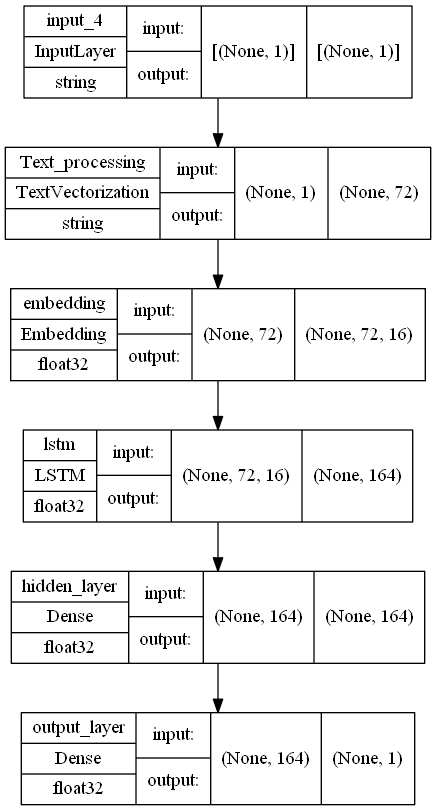

In [120]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [121]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 213s 279ms/step - loss: 5.8879 - mean_squared_error: 243.8778 - mean_absolute_error: 5.8879 - val_loss: 2.5533 - val_mean_squared_error: 9.6916 - val_mean_absolute_error: 2.5533
Epoch 2/20
750/750 [==============================] - 202s 269ms/step - loss: 2.5409 - mean_squared_error: 9.7490 - mean_absolute_error: 2.5409 - val_loss: 2.6069 - val_mean_squared_error: 10.3411 - val_mean_absolute_error: 2.6069
Epoch 3/20
750/750 [==============================] - 201s 268ms/step - loss: 2.5505 - mean_squared_error: 9.8461 - mean_absolute_error: 2.5505 - val_loss: 2.5394 - val_mean_squared_error: 9.8009 - val_mean_absolute_error: 2.5394
Wall time: 10min 17s


##### Model evaluation:

In [122]:
test_data['predicted_score_LSTM'] = model.predict(test_data[text_col])

In [123]:
LSTM_stats = calc_prediction_quality(test_data, 'predicted_score_LSTM', target_col)
LSTM_stats

MSE    9.691631
MAE    2.553311
R2    -0.000709
dtype: float64

In [124]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_desc_stats, extended_NLP_stats, fully_connected_NN_stats, fully_connected_NN_concatinated_words_stats, DNN_external_embedding_stats, LSTM_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'NLP_desc_stats', 'extended_NLP_stats', 'fully_connected_NN', 'fully_connected_NN_concatinated_words', 'DNN_external_embedding_stats', 'LSTM'])
all_compared

,MSE,MAE,R2
baseline_1,9.684853,2.558104,-0.000009
baseline_2,9.168517,2.481975,0.053305
baseline_3,8.599106,2.382239,0.112099
regression_by_xgb,6.375198,1.912409,0.341729
NLP_desc_stats,2.571613,1.266684,0.731173
extended_NLP_stats,2.489510,1.238033,0.739756
fully_connected_NN,2.935073,1.352488,0.696939
fully_connected_NN_concatinated_words,10.388935,2.612426,-0.072709
DNN_external_embedding_stats,5.553059,1.879923,0.426619
LSTM,9.691631,2.553311,-0.000709


In [125]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

### Bonus task: Using all features applying the Keras Functional API

In [126]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, concatenate

In [127]:
# Define two sets of inputs: InputA is the 'description' text feature, InputB is the rest of the features which we already labeled before.
inputA = Input(shape=(1,), name="text input layer", dtype=tf.string)
inputB = Input(shape=(8,), name="other features input layer")

# The first branch operates on InputA: 
x = vectorize_layer(inputA)
x = Embedding(vocab_size, embedding_dim, name="embedding")(x)
x = GlobalAveragePooling1D()(x)
x = Dense(164, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(164, activation='relu')(x)
x = Model(inputs=inputA, outputs=x)

# The second branch opreates on InputB:
y = Dense(164, activation="relu")(inputB)
y = Dropout(0.2)(y)
y = Dense(164, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)

# Combine the output of the two branches
combined = concatenate([x.output, y.output])

# Apply a fully-connected layer and then a regression prediction on the combined outputs
z = Dense(164, activation="relu")(combined)
z = Dense(1, activation="linear")(z)

# Define a model that will accept the inputs of the two branches and then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [128]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

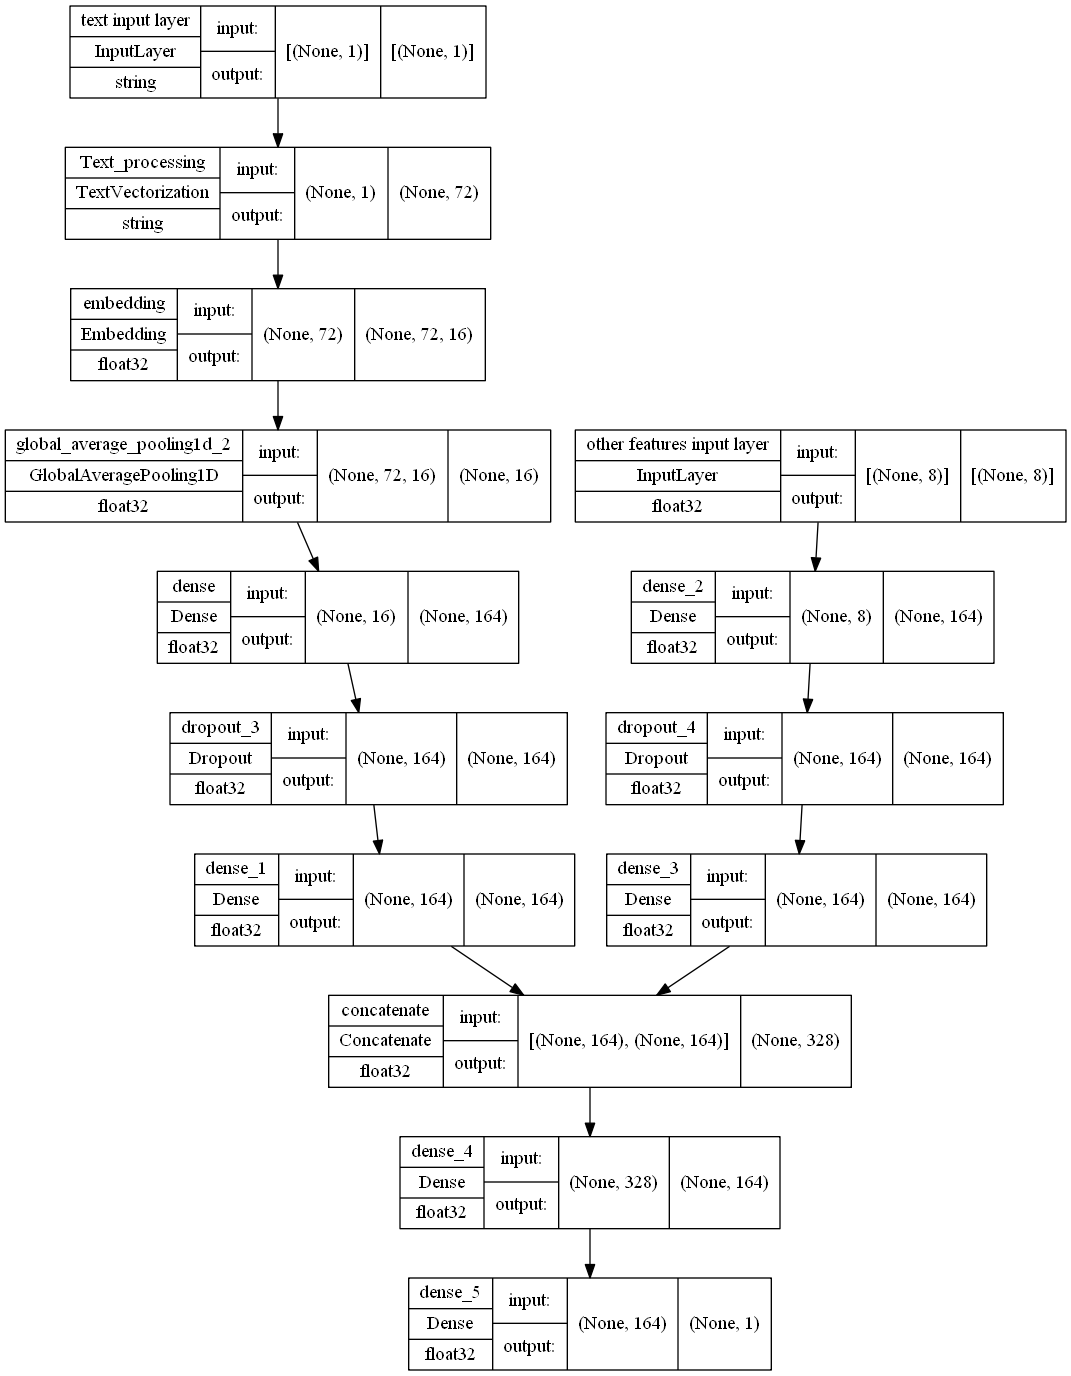

In [129]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

Preparing the Train and Test datasets:

In [130]:
# organizing the Text train and test datasets
trainTextX = train_data[text_col]
testTextX = test_data[text_col]

In [131]:
# organizing the train and test datasets of the rest of features and which we already encoded before 
trainAttrX = train_encoded_features.loc[:,train_encoded_features.columns != 'points']
testAttrX = test_encoded_features.loc[:,test_encoded_features.columns != 'points']
testAttrX = testAttrX.drop(['xgb_clf_points_prediction'], axis=1)

In [132]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    x= [trainTextX, trainAttrX],
    y = train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = ([testTextX, testAttrX], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 19s 23ms/step - loss: 19.2721 - mean_squared_error: 2728.8604 - mean_absolute_error: 19.2721 - val_loss: 7.4789 - val_mean_squared_error: 71.4285 - val_mean_absolute_error: 7.4789
Epoch 2/20
750/750 [==============================] - 17s 23ms/step - loss: 4.7155 - mean_squared_error: 36.6466 - mean_absolute_error: 4.7155 - val_loss: 1.7144 - val_mean_squared_error: 4.7591 - val_mean_absolute_error: 1.7144
Epoch 3/20
750/750 [==============================] - 17s 22ms/step - loss: 3.7271 - mean_squared_error: 22.1970 - mean_absolute_error: 3.7271 - val_loss: 1.8694 - val_mean_squared_error: 5.4699 - val_mean_absolute_error: 1.8694
Epoch 4/20
750/750 [==============================] - 17s 23ms/step - loss: 2.7954 - mean_squared_error: 12.5180 - mean_absolute_error: 2.7954 - val_loss: 1.4713 - val_mean_squared_error: 3.4451 - val_mean_absolute_error: 1.4713
Epoch 5/20
750/750 [==============================] - 17s 22ms/step - loss: 1.9

##### Model evaluation:

In [133]:
test_data['Multiple_Inputs_Mixed_Data_NN_Functional_API'] = model.predict([testTextX, testAttrX])

In [134]:
Multiple_Inputs_Mixed_Data_NN_Functional_API_stats = calc_prediction_quality(test_data, 'Multiple_Inputs_Mixed_Data_NN_Functional_API', target_col)
Multiple_Inputs_Mixed_Data_NN_Functional_API_stats

MSE    3.445103
MAE    1.471253
R2     0.644276
dtype: float64

In [135]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, NLP_desc_stats, extended_NLP_stats, fully_connected_NN_stats, fully_connected_NN_concatinated_words_stats, DNN_external_embedding_stats, LSTM_stats, Multiple_Inputs_Mixed_Data_NN_Functional_API_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'NLP_desc_stats', 'extended_NLP_stats', 'fully_connected_NN', 'fully_connected_NN_concatinated_words', 'DNN_external_embedding_stats', 'LSTM', 'Multiple_Inputs_Mixed_Data_NN_Functional_API'])
all_compared

,MSE,MAE,R2
baseline_1,9.684853,2.558104,-0.000009
baseline_2,9.168517,2.481975,0.053305
baseline_3,8.599106,2.382239,0.112099
regression_by_xgb,6.375198,1.912409,0.341729
NLP_desc_stats,2.571613,1.266684,0.731173
extended_NLP_stats,2.489510,1.238033,0.739756
fully_connected_NN,2.935073,1.352488,0.696939
fully_connected_NN_concatinated_words,10.388935,2.612426,-0.072709
DNN_external_embedding_stats,5.553059,1.879923,0.426619
LSTM,9.691631,2.553311,-0.000709


The network with multiple inputs and mixed data (text and other features) yielded a prety good result - similar to, yet slightly lower than, the classical NLP regression model with the other parameters.
After running several rounds of executining all the models, the best performing model (consistently in every round) is the classical NLP regression model with the other parameters. 

In [136]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Visualization

In [137]:
import plotly_express as px

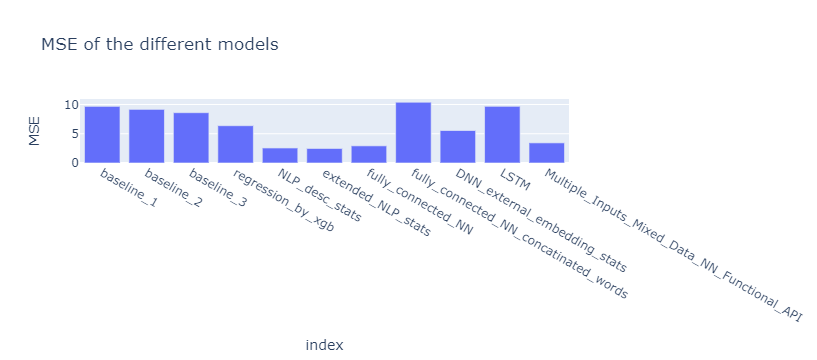

In [138]:
px.bar(all_compared, x=all_compared.index, y='MSE', 
        title="MSE of the different models")

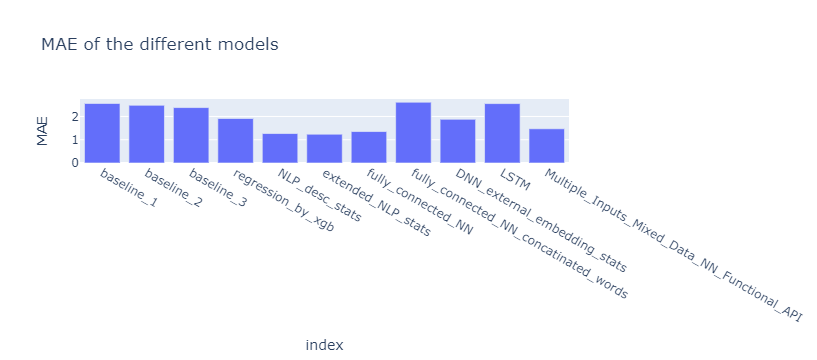

In [139]:
px.bar(all_compared, x=all_compared.index, y='MAE', 
        title="MAE of the different models")